In [9]:
# Lane line detection from image and video

In [13]:
# First for Image

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mplPath
import numpy as np
import cv2
import math
%matplotlib inline


In [2]:
## All required Functions

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def gaussian_blur(gray_img, kernel_size):
    return cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 0)

def canny(gaussian_img, low_threshold, high_threshold):
    return cv2.Canny(gaussian_img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    #[slopeSum, count, yIntersectSum, x, y]
    leftLane = [0, 0, 0, 0, 0]
    rightLane = [0, 0, 0, 0, 0]
    
    # Image dimentions (y, x): 540, 960 
    
    vertices = np.array([[100,540],[420, 330], [520, 330], [900,540]])
    bbPath = mplPath.Path(vertices)
    
    minX = 100
    maxX = 900
    
    minY = 330
    maxY = 540
    
    for line in lines:
        for x1,y1,x2,y2 in line:        
            # Only calculate slope if it's within our bounded region
            if (bbPath.contains_point([x1, y1]) is not True):
                continue
            m = (y2 - y1) / (x2 - x1)
            #b = y - mx
            b = y1 - (m * x1)
            if (m > 0):
                rightLane[0] = rightLane[0] + m
                rightLane[1] += 1
                rightLane[2] += b
                rightLane[3] = x1
                rightLane[4] = y1
            else:
                leftLane[0] = leftLane[0] + m
                leftLane[1] += 1
                leftLane[2] += b
                leftLane[3] = x1
                leftLane[4] = y1
            
            #cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], 2)
    
    left_lane_slope = 0
    left_lane_y_intercept = 0
    right_lane_slope = 0
    right_lane_y_intercept = 0
    
    global last_slope_left
    global last_slope_right
    
    if (leftLane[1] != 0):
        left_lane_slope = leftLane[0] / leftLane[1]
        left_lane_y_intercept = leftLane[2] / leftLane[1]
        last_slope_left = left_lane_slope
    else:
        left_lane_slope = last_slope_left
    
    if (rightLane[1] != 0):
        right_lane_slope = rightLane[0] / rightLane[1]
        right_lane_y_intercept = rightLane[2] / rightLane[1]
        last_slope_right = right_lane_slope
    else:
        right_lane_slope = last_slope_right
    
    
    # x = (y - b) / m
    # y = mx + b
    x_bottom_left_lane = (maxY - left_lane_y_intercept) / left_lane_slope
    y_bottom_left_lane = left_lane_slope * x_bottom_left_lane + left_lane_y_intercept

    
    x_top_left_lane = (minY - left_lane_y_intercept) / left_lane_slope
    y_top_left_lane = left_lane_slope * x_top_left_lane + left_lane_y_intercept
    
    cv2.line(img, (int(round(x_bottom_left_lane)), int(round(y_bottom_left_lane))), (int(round(x_top_left_lane)), int(round(y_top_left_lane))), [255, 0, 0], thickness)
    
    
    minX_right = 100
    maxX_right = 900
    
    minY_right = 330
    maxY_right = 540
    
    x_bottom_right_lane = (maxY_right - right_lane_y_intercept) / right_lane_slope
    y_bottom_right_lane = right_lane_slope * x_bottom_right_lane + right_lane_y_intercept
    
    x_top_right_lane = (minY - right_lane_y_intercept) / right_lane_slope
    y_top_right_lane = right_lane_slope * x_top_right_lane + right_lane_y_intercept
    
    cv2.line(img, (int(round(x_bottom_right_lane)), int(round(y_bottom_right_lane))), (int(round(x_top_right_lane)), int(round(y_top_right_lane))), [0, 255, 0], thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, [0, 255, 0], 15)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
# Test images
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


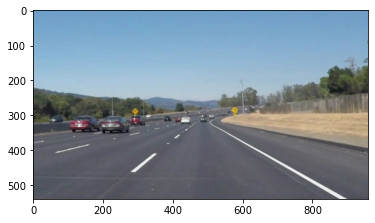

In [4]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

# All the test images must be of dimensions (540, 960, 3)

Lane detection from Image


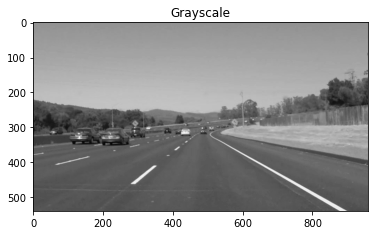

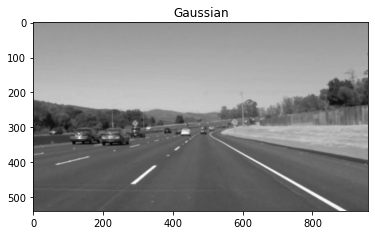

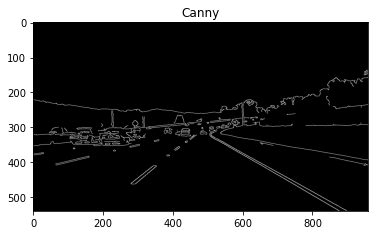

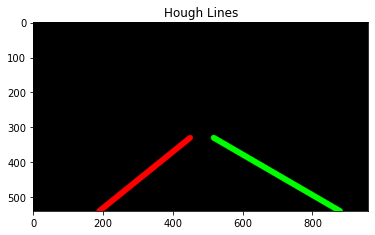

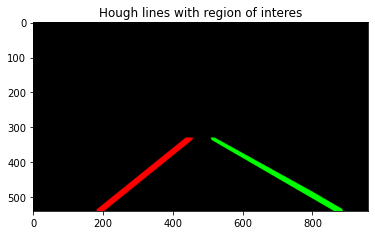

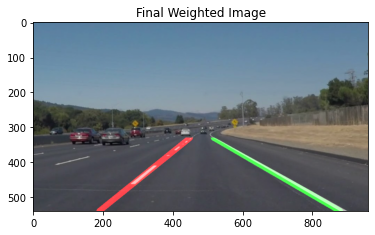

In [5]:

gray_img = grayscale(image)
gaussian_img = gaussian_blur(gray_img, 5)   # kernal size=5
canny_img = canny(gaussian_img, 50, 150)    # Low and high thresholds are 50, 150

# Now let's run the Hough lines
rho = 1                 # distance resolution in pixels of the Hough grid
theta = np.pi/180       # angular resolution in radians of the Hough grid
threshold = 20          # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30    # minimum number of pixels making up a line
max_line_gap = 3        # maximum gap in pixels between connectable line segments

hough_img = hough_lines(canny_img, rho, theta, threshold, min_line_length, max_line_gap)

imshape = hough_img.shape
vertices = np.array([[(100,imshape[0]),(420, 330), (520, 330), (imshape[1]-60,imshape[0])]], dtype=np.int32)


reg_interest_img = region_of_interest(hough_img, vertices)

final_image = weighted_img(reg_interest_img, image)

print("Lane detection from Image")

plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale")
plt.show()

plt.imshow(gaussian_img, cmap='gray')
plt.title("Gaussian")
plt.show()

plt.imshow(canny_img, cmap='gray')
plt.title("Canny")
plt.show()

plt.imshow(hough_img, cmap='gray')
plt.title("Hough Lines")
plt.show()

plt.imshow(reg_interest_img, cmap='gray')
plt.title("Hough lines with region of interes")
plt.show()

plt.imshow(final_image, cmap='gray')
plt.title("Final Weighted Image")
plt.show()


In [6]:
# For Video

In [7]:
# Import everything needed to edit/save/watch video clips
from IPython.display import HTML
from moviepy.editor import VideoFileClip

In [8]:
# returns a color image (3 channel) for processing video below
def process_image(image):
    gray_img = grayscale(image)
    gaussian_img = gaussian_blur(gray_img, 5)
    canny_img = canny(gaussian_img, 50, 150)

    # Now let's run the Hough lines
    rho = 1                 # distance resolution in pixels of the Hough grid
    theta = np.pi/180       # angular resolution in radians of the Hough grid
    threshold = 20          # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30    # minimum number of pixels making up a line
    max_line_gap = 3        # maximum gap in pixels between connectable line segments

    hough_img = hough_lines(canny_img, rho, theta, threshold, min_line_length, max_line_gap)

    imshape = hough_img.shape
    vertices = np.array([[(100,imshape[0]),(420, 330), (520, 330), (imshape[1]-60,imshape[0])]], dtype=np.int32)

    reg_interest_img = region_of_interest(hough_img, vertices)

    final_image = weighted_img(reg_interest_img, image)

    return final_image

In [21]:
# List of test-Videos
import os
os.listdir("test_videos/")

['challenge.mp4', 'solidWhiteRight.mp4', 'solidYellowLeft.mp4']

In [16]:
# Testing video solidWhiteRight.mp4

In [22]:
white_output = 'test_videos_output/output_solidWhiteRight.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)





t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]Moviepy - Building video test_videos_output/output_solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/output_solidWhiteRight.mp4





t:   1%|          | 2/221 [00:00<00:20, 10.94it/s, now=None]



t:   2%|▏         | 4/221 [00:00<00:17, 12.49it/s, now=None]



t:   3%|▎         | 6/221 [00:00<00:15, 13.67it/s, now=None]



t:   4%|▎         | 8/221 [00:00<00:14, 14.68it/s, now=None]



t:   5%|▍         | 10/221 [00:00<00:13, 15.58it/s, now=None]



t:   5%|▌         | 12/221 [00:00<00:12, 16.32it/s, now=None]



t:   6%|▋         | 14/221 [00:00<00:12, 16.19it/s, now=None]



t:   7%|▋         | 16/221 [00:00<00:12, 16.53it/s, now=None]



t:   8%|▊         | 18/221 [00:01<00:11, 17.24it/s, now=None]



t:   9%|▉         | 20/221 [00:01<00:11, 17.54it/s, now=None]



t:  10%|▉         | 22/221 [00:01<00:11, 17.82it/s, now=None]



t:  11%|█         | 24/221 [00:01<00:11, 17.68it/s, now=None]



t:  12%|█▏        | 2

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [24]:
# Testing video solidYellowLeft.mp4

In [39]:
yellow_output = 'test_videos_output/output_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[A



t:  30%|██▉       | 201/681 [00:25<01:35,  5.04it/s, now=None]



t:  30%|██▉       | 202/681 [00:26<04:05,  1.95it/s, now=None]



t:  30%|██▉       | 203/681 [00:26<03:08,  2.53it/s, now=None]



t:  30%|██▉       | 204/681 [00:26<02:35,  3.06it/s, now=None]



t:  30%|███       | 206/681 [00:27<02:18,  3.43it/s, now=None]



t:  31%|███       | 208/681 [00:27<02:07,  3.70it/s, now=None]



t:  31%|███       | 210/681 [00:28<01:53,  4.14it/s, now=None]



t:  31%|███       | 212/681 [00:28<01:30,  5.17it/s, now=None]



t:  31%|███▏      | 213/681 [00:28<01:55,  4.05it/s, now=None]



t:  31%|███▏      | 214/681 [00:29<02:25,  3.22it/s, now=None]



t:  32%|███▏      | 216/681 [00:29<01:49,  4.26it/s, now=None]



t:  32%|███▏      | 218/681 [00:29<02:01,  3.82it/s, now=None]



t:  32%|███▏      | 219/681 [00:30<02:04,  3.72it/s, now=None]



t:  32%|███▏      | 221/681 [00:30<01:36,  4.75it/s, now=None]



t:  33%|███▎      | 222/681 [00:30<01:42,  4.50it/s, now=None]



t:  

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))
